Ignacy Berent 275255

Michał Dziak 

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Collecting

In [82]:
def set_column_names():
    global column_names
    names = []
    # First 15 columns
    names.extend([
        "Age",
        "Sex",
        "Height",
        "Weight",
        "QRS duration",
        "P-R interval",
        "Q-T interval",
        "T interval",
        "P interval",
        "QRS angle",
        "T angle",
        "P angle",
        "QRST angle",
        "J angle",
        "Heart rate"
    ])
    
    # Define metrics for average width groups (in msec)
    width_metrics = [
        "Q wave",
        "R wave",
        "S wave",
        "R' wave",
        "S' wave",
        "Number of intrinsic deflections",
        "Existence of ragged R wave",
        "Existence of diphasic derivation of R wave",
        "Existence of ragged P wave",
        "Existence of diphasic derivation of P wave",
        "Existence of ragged T wave",
        "Existence of diphasic derivation of T wave"
    ]
    # Channels for average width attributes
    channels_width = ["DI", "DII", "DIII", "AVR", "AVL", "AVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    for channel in channels_width:
        for metric in width_metrics:
            # Append channel info plus metric and indication that these are width measurements
            names.append(f"{channel} {metric} (width)")
    
    # Define metrics for amplitude groups (amplitude * 0.1 mV)
    amplitude_metrics = [
        "JJ wave",
        "Q wave",
        "R wave",
        "S wave",
        "R' wave",
        "S' wave",
        "P wave",
        "T wave",
        "QRSA",
        "QRSTA"
    ]
    # Channels for amplitude attributes
    channels_amplitude = ["DI", "DII", "DIII", "AVR", "AVL", "AVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    for channel in channels_amplitude:
        for metric in amplitude_metrics:
            names.append(f"{channel} {metric} (amplitude)")
            
    names.append("Class code")
    column_names = names

# Initialize column_names by calling the function
set_column_names()
print(column_names[167])

DI QRSA (amplitude)


In [83]:
df = pd.read_csv('data/arrhythmia.data', header=None, na_values='?', names=column_names)
df.head()

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS angle,...,V6 Q wave (amplitude),V6 R wave (amplitude),V6 S wave (amplitude),V6 R' wave (amplitude),V6 S' wave (amplitude),V6 P wave (amplitude),V6 T wave (amplitude),V6 QRSA (amplitude),V6 QRSTA (amplitude),Class code
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


# Cleaning

## Duplicates

In [84]:
# check for duplicates
duplicates = df.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

Number of duplicates: 0


## Nan values

In [85]:
# check missing data
missing = df.isnull().sum()
print(f"Missing data: {missing.sum()}")

Missing data: 408


In [86]:
# check where missing data is
missing = df.isnull().sum()
missing = missing[missing > 0]
print(f"Missing data in columns: \n{missing}")

Missing data in columns: 
T angle         8
P angle        22
QRST angle      1
J angle       376
Heart rate      1
dtype: int64


In [87]:
# remove J angle column due to high number of missing values
df = df.drop(columns=["J angle"])

# fill remaining missing values with median since it is the easiest way
df['T angle'] = df['T angle'].fillna(df['T angle'].median())
df['P angle'] = df['P angle'].fillna(df['P angle'].median())
df['QRST angle'] = df['QRST angle'].fillna(df['QRST angle'].median())
df['Heart rate'] = df['Heart rate'].fillna(df['Heart rate'].median())

In [88]:
# check where missing data is
missing = df.isnull().sum()
missing = missing[missing > 0]
print(f"Missing data in columns: \n{missing}")

Missing data in columns: 
Series([], dtype: int64)


## Outliers

In [89]:
# check for outliers
df.describe()

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS angle,...,V6 Q wave (amplitude),V6 R wave (amplitude),V6 S wave (amplitude),V6 R' wave (amplitude),V6 S' wave (amplitude),V6 P wave (amplitude),V6 T wave (amplitude),V6 QRSA (amplitude),V6 QRSTA (amplitude),Class code
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,...,-0.278982,9.048009,-1.457301,0.003982,0.0,0.514823,1.222345,19.326106,29.473230,3.880531
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,...,0.548876,3.472862,2.002430,0.050118,0.0,0.347531,1.426052,13.503922,18.493927,4.407097
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,...,-4.100000,0.000000,-28.600000,0.000000,0.0,-0.800000,-6.000000,-44.200000,-38.600000,1.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,...,-0.425000,6.600000,-2.100000,0.000000,0.0,0.400000,0.500000,11.450000,17.550000,1.000000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.000000,367.000000,162.000000,91.000000,40.000000,...,0.000000,8.800000,-1.100000,0.000000,0.0,0.500000,1.350000,18.100000,27.900000,1.000000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.000000,384.000000,179.000000,102.000000,66.000000,...,0.000000,11.200000,0.000000,0.000000,0.0,0.700000,2.100000,25.825000,41.125000,6.000000
max,83.000000,1.000000,780.000000,176.000000,188.000000,524.000000,509.000000,381.000000,205.000000,169.000000,...,0.000000,23.600000,0.000000,0.800000,0.0,2.400000,6.000000,88.800000,115.900000,16.000000


In [90]:
# calculate z-scores for each column
z_scores = (df - df.mean()) / df.std()
# calculate the absolute z-scores
z_scores = z_scores.abs()
# check for outliers
outliers = z_scores > 3
outliers = outliers.sum()
print(f"Number of outliers: \n{outliers}")
print(sum(outliers))

Number of outliers: 
Age                       0
Sex                       0
Height                    2
Weight                    7
QRS duration             11
                         ..
V6 P wave (amplitude)     4
V6 T wave (amplitude)     6
V6 QRSA (amplitude)       5
V6 QRSTA (amplitude)      5
Class code                0
Length: 279, dtype: int64
1513


In [91]:
# cap the outliers with winsorization
# define the quantile limits
lower_limit = 0.01
upper_limit = 0.99
# calculate the quantile values
lower_quantile = df.quantile(lower_limit)
upper_quantile = df.quantile(upper_limit)
# cap the values
df = df.clip(lower_quantile, upper_quantile, axis=1)

# Imbalance

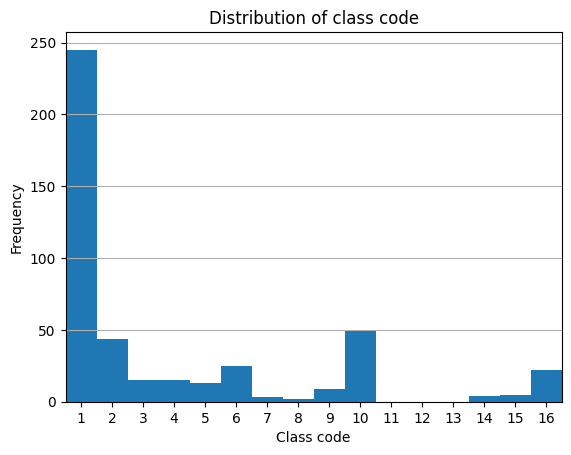

In [114]:
edges = np.linspace(1, 17, 17)
df['Class code'].hist(bins=edges)
plt.title('Distribution of class code')
plt.xlabel('Class code')
plt.ylabel('Frequency')

# calculate bin centers
bin_centers = edges[:-1] + (edges[1] - edges[0]) / 2
plt.xticks(bin_centers, labels=np.arange(1, 17))
plt.xlim(1, 17)
plt.grid(axis='x')
plt.show()

In [121]:
# use XGBoost to classify the data
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

In [122]:
# split the data into features and target
X = df.drop(columns=['Class code'])
y = df['Class code']

In [123]:
# split the data into training and testing sets
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [124]:
# initialize the model
model = XGBClassifier()

# calculate the cross validation score
results = cross_val_score(model, X, y, cv=skfold, scoring='accuracy')
print(f"Accuracy: {results.mean()}")
print(f"Standard deviation: {results.std()}")
print(results)

c:\Users\user\Desktop\AI_1\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\Desktop\AI_1\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\Desktop\AI_1\.venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\user\Desktop\AI_1\.venv\Lib\site-packages\xgboost\sklearn.py", line 1640, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12], got [ 1  2  3  4  5  6  7  8  9 10 14 15 16]
